<a href="https://colab.research.google.com/github/ainulmrdh02/FYP/blob/main/Denoising_unet__Autoencoder_(MRI).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
!kaggle datasets download -d volodymyrpivoshenko/brain-mri-scan-images-tumor-detection

Dataset URL: https://www.kaggle.com/datasets/volodymyrpivoshenko/brain-mri-scan-images-tumor-detection
License(s): CC0-1.0
 75% 5.00M/6.65M [00:00<00:00, 36.2MB/s]
100% 6.65M/6.65M [00:00<00:00, 46.5MB/s]


In [ ]:
import os
from glob import glob
import cv2

import torch
import torch.nn as nn
import torchvision.transforms as T
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset, random_split
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr

from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class CustomMRIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)

    def __len__(self):
        return len(os.listdir(os.path.join(self.root_dir, self.classes[0])))

    def __getitem__(self, idx):
        img_name = os.listdir(os.path.join(self.root_dir, self.classes[0]))[idx]
        img_path = os.path.join(self.root_dir, self.classes[0], img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, 0  # Return 0 as label for simplicity (adjust as per your dataset)

In [ ]:
import zipfile
import os

# Path to the ZIP file
zip_file = '/content/brain-mri-scan-images-tumor-detection.zip'

# Directory to extract the ZIP file contents
extract_dir = '/content/brain_mri_data'

# Extract the ZIP file
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Now define the dataset directory
data_dir = extract_dir

# Verify the contents after extraction
print(os.listdir(data_dir))  # Should list the contents of the extracted directory

['brain_mri_scan_images']


In [ ]:
torch.backends.cudnn.benchmark = True
torch.manual_seed(42)

In [ ]:
# Define transformations
transform = T.Compose([
    T.Resize((256, 256)),  # Resize to 256x256
    T.ToTensor(),  # Convert to tensor
])

# Path to the dataset directory after extraction
data_dir = '/content/brain_mri_data'

# Create the dataset without normalization for now
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Define the sizes of train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split dataset into train and test sets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Define batch sizes
batch_size = 16

# Create DataLoaders for train and test sets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class Autoencoder(nn.Module):
  def __init__(self):
      super(Autoencoder, self).__init__()
      self.encoder = nn.Sequential(
          nn.Conv2d(3, 32, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
          nn.Conv2d(32, 64, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
          nn.Conv2d(64, 128, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
      )

      self.decoder = nn.Sequential(
          nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
          nn.ReLU(),
          nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
          nn.ReLU(),
          nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
          nn.Sigmoid()
      )

  def forward(self, x):
      x = self.encoder(x)
      x = self.decoder(x)
      return x

In [ ]:
def add_noise(img, noise_factor=0.8):
    noise = torch.randn_like(img) * noise_factor
    noisy_img = img + noise
    return torch.clamp(noisy_img, 0., 1.)

In [ ]:
device = torch.device('cuda')
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-03)

num_epochs = 50
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, _ in train_dataloader:
        images = images.to(device)
        noisy_images = add_noise(images)

        optimizer.zero_grad()
        outputs = model(noisy_images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_dataloader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}')

print('Training Finished')

Epoch 1/50, Loss: 0.09764206862252062
Epoch 2/50, Loss: 0.05991062896521711
Epoch 3/50, Loss: 0.030622825541055006
Epoch 4/50, Loss: 0.025422255873927095
Epoch 5/50, Loss: 0.022525686009154135
Epoch 6/50, Loss: 0.019857400318206344
Epoch 7/50, Loss: 0.018639973977076413
Epoch 8/50, Loss: 0.016511589226966404
Epoch 9/50, Loss: 0.014994062498746985
Epoch 10/50, Loss: 0.013906860960781245
Epoch 11/50, Loss: 0.012793492006127677
Epoch 12/50, Loss: 0.011945296480263795
Epoch 13/50, Loss: 0.011688156506221598
Epoch 14/50, Loss: 0.01169813847817604
Epoch 15/50, Loss: 0.011277704432771351
Epoch 16/50, Loss: 0.01115425930291579
Epoch 17/50, Loss: 0.01095891622466277
Epoch 18/50, Loss: 0.010710788890719414
Epoch 19/50, Loss: 0.010411402331510795
Epoch 20/50, Loss: 0.010124377515269907
Epoch 21/50, Loss: 0.009954183496205518
Epoch 22/50, Loss: 0.009828121890185287
Epoch 23/50, Loss: 0.009590183503061369
Epoch 24/50, Loss: 0.00950748104993151
Epoch 25/50, Loss: 0.009497210964848653
Epoch 26/50, Lo

In [ ]:
def denoise_image(image, model):
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0)
        output = model(image)
    return output.squeeze(0)

In [ ]:
# Function to calculate PSNR
def calculate_psnr(img1, img2):
    # Convert torch tensors to numpy arrays
    img1_np = img1.cpu().detach().numpy()
    img2_np = img2.cpu().detach().numpy()

    # Ensure images are in correct data range and type
    img1_np = img1_np.astype(np.float32)
    img2_np = img2_np.astype(np.float32)

    img_psnr = psnr(img1_np, img2_np, data_range=1.0)
    return img_psnr

# Function to calculate SSIM
def calculate_ssim(img1, img2):
    # Convert torch tensors to numpy arrays
    img1_np = img1.cpu().detach().numpy()
    img2_np = img2.cpu().detach().numpy()

    # Ensure images are in correct data range and type
    img1_np = img1_np.astype(np.float32)
    img2_np = img2_np.astype(np.float32)

    # Calculate SSIM with the appropriate window size
    img_ssim = ssim(img1_np, img2_np, data_range=1, win_size=3)

    return img_ssim

PSNR (Noisy): 7.2233, SSIM (Noisy): 0.0292
PSNR (Denoised): 18.2745, SSIM (Denoised): 0.5856


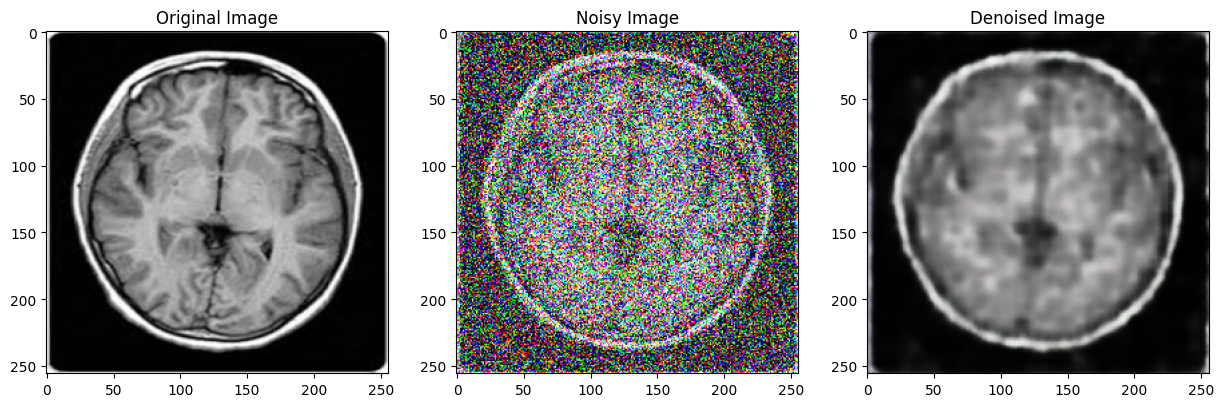

In [ ]:
# Load a test image
test_image = test_dataset[0][0]  # Get the first image from the dataset

noisy_test_image = add_noise(test_image).to(device)

# Denoise the image using the trained model
denoised_image = denoise_image(noisy_test_image, model)

denoised_image = denoised_image.cpu()
noisy_test_image = noisy_test_image.cpu()

psnr_value_denoised = calculate_psnr(test_image, noisy_test_image)
ssim_value_denoised = calculate_ssim(test_image, noisy_test_image)
print(f'PSNR (Noisy): {psnr_value_denoised:.4f}, SSIM (Noisy): {ssim_value_denoised:.4f}')

psnr_value_denoised = calculate_psnr(test_image, denoised_image)
ssim_value_denoised = calculate_ssim(test_image, denoised_image)
print(f'PSNR (Denoised): {psnr_value_denoised:.4f}, SSIM (Denoised): {ssim_value_denoised:.4f}')

test_image = np.clip(test_image, 0, 1)
noisy_test_image = np.clip(noisy_test_image, 0, 1)
denoised_image = np.clip(denoised_image, 0, 1)

# Plot the results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(test_image.permute(1, 2, 0))  # permute to (H, W, C) for plotting
plt.subplot(1, 3, 2)
plt.title('Noisy Image')
plt.imshow(noisy_test_image.permute(1, 2, 0))  # permute to (H, W, C) for plotting
plt.subplot(1, 3, 3)
plt.title('Denoised Image')
plt.imshow(denoised_image.permute(1, 2, 0))  # permute to (H, W, C) for plotting
plt.show()